In [1]:
#!pip install ngrok -q
#!pip install dash -q
#!pip install "dash[diskcache]" -q

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig, AutoConfig, StoppingCriteriaList, StoppingCriteria
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import itertools
import torch

In [2]:
# https://github.com/oobabooga/text-generation-webui/blob/2cf711f35ec8453d8af818be631cb60447e759e2/modules/callbacks.py#L12
class _SentinelTokenStoppingCriteria(StoppingCriteria):
    def __init__(self, sentinel_token_ids: list, starting_idx: int):
        StoppingCriteria.__init__(self)
        self.sentinel_token_ids = sentinel_token_ids
        self.starting_idx = starting_idx
        self.shortest = min([x.shape[-1] for x in sentinel_token_ids])

    def __call__(self, input_ids: torch.LongTensor, _scores: torch.FloatTensor) -> bool:
        for sample in input_ids:
            trimmed_sample = sample[self.starting_idx:]
            trimmed_len = trimmed_sample.shape[-1]
            if trimmed_len < self.shortest:
                continue

            for sentinel in self.sentinel_token_ids:
                sentinel_len = sentinel.shape[-1]
                if trimmed_len < sentinel_len:
                    continue

                window = trimmed_sample[-sentinel_len:]
                if torch.all(torch.eq(sentinel, window)):
                    return True

        return False
####

def generate_stopping_criteria(stopgen_tokens, input_len=0):
    return StoppingCriteriaList([
        _SentinelTokenStoppingCriteria(
            sentinel_token_ids = stopgen_tokens,
            starting_idx=input_len
        )
    ])


# CODE

In [3]:
#model_id = "microsoft/phi-1_5"
#model_id = "meta-llama/Llama-2-7b-hf"
model_id = "mistralai/Mistral-7B-v0.1"
torch.set_default_device("cpu")

In [ ]:
hf_key = ""
if model_id in ["meta-llama/Llama-2-7b-hf"]:
    hf_key = input("Hugging Face Key: ")
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True, token=hf_key)
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, token=hf_key)
model_config = AutoConfig.from_pretrained(model_id, trust_remote_code=True, token=hf_key)
del hf_key

In [5]:
if model_id in ["microsoft/phi-1_5"]:
    stopgen_tokens = [
        torch.tensor([198, 198]),  # \n\n
        torch.tensor([628])        # \n\n
    ]
    prompt_structure = "Question: {prompt}\n\nAnswer:"
    exclude_token_offset = 3
    fix_characters = [("Ġ", "␣"), ("Ċ", "\n")]
elif model_id in ["meta-llama/Llama-2-7b-hf", "mistralai/Mistral-7B-v0.1"]:
    stopgen_tokens = [
        torch.tensor([1]),  # <s>
        torch.tensor([2])   # </s>
    ]
    prompt_structure = "{prompt}"
    exclude_token_offset = None
    fix_characters = [("<0x0A>", "\n")]

fix_characters += [("\n", "\\n")]

In [6]:
if tokenizer.eos_token_id and not tokenizer.pad_token_id:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

In [7]:
### ALTERATION ### Divided computation for attentions
### ALTERATION ###  Added function to compute attentions also for prompt

def pad_masked_attentions(attentions, max_len):
    """
    Attention in generative models are masked, we want to plot a heatmap so we must pad all attentions to the same size with 0.0 values
    """
    array_attentions = [np.array(att) for att in attentions]
    new_attentions = [np.concatenate([att, np.zeros([max_len - len(att)])]) for att in array_attentions]
    return np.array(new_attentions)

def compute_complete_padded_attentions(generated_output, layer, head):
    single_layer_attentions = []
    # Prompt tokens
    for single_layer_single_head in torch.squeeze(torch.select(generated_output.attentions[0][layer], 1, head)):
        single_layer_attentions.append(single_layer_single_head)
    # Response tokens
    for attentions_per_token in generated_output.attentions[1:]:
        # Take single layer
        single_layer = attentions_per_token[layer]
        # Take only one head
        single_layer_single_head = torch.select(single_layer, 1, head)
        single_layer_attentions.append(single_layer_single_head)
    # Squeeze dimensions to one a one-dimensional tensor
    pure_attentions = [s.squeeze() for s in single_layer_attentions]
    max_seq_len  = len(pure_attentions[-1])
    # Print last attention heatmap
    padded_attentions = pad_masked_attentions(pure_attentions, max_seq_len)
    return padded_attentions

def compute_batch_complete_padded_attentions(generated_output, heads):
    multi_layer_head_attentions = []
    for head in heads:
        multi_layer_attentions = []
        for layer in range(0, len(generated_output.attentions[0])):
            # Prompt tokens
            prompt_att = [
                torch.squeeze(single_head)
                for single_head in torch.squeeze(torch.select(generated_output.attentions[0][layer], 1, head))
            ]
            # Response tokens
            response_att = [
                torch.squeeze(torch.select(single_layer[layer], 1, head))
                for single_layer in generated_output.attentions[1:]
            ]
            # Pad and merge attentions
            multi_layer_attentions.append(pad_masked_attentions( 
                [att_token for att_token in prompt_att + response_att],
                len(response_att[-1])
            ))
        multi_layer_head_attentions.append(multi_layer_attentions)
    return multi_layer_head_attentions

def plot_attentions(generated_output, layer, head, generated_tokens, past_tokens):
    # Plot 
    data = compute_padded_attentions(generated_output, layer, head)
    fig, ax = plt.subplots(figsize = (12,5))
    im = ax.imshow(data)
    # Show all ticks and label them with the respective list entries
    ax.set_yticks(np.arange(len(generated_tokens)), labels=generated_tokens)
    ax.set_xticks(np.arange(len(past_tokens)), labels=past_tokens, fontsize=8)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    ax.set_title(f"Heatmap of attention layers: layer {layer} head {head}")
    fig.tight_layout()
    plt.show()

In [8]:
### ALTERATION ### Adapted functions to work outside model
### ALTERATION ### Added option to include hidden states for prompt and ending token in embed_hidden_states
def _apply_lm_head(model, hidden_states, weights, bias):
    """
    Function which takes as input the hidden states of the model and returns the prediction of the next token.
    Uses the language modeling head of input
    """
    pred_ids = []
    for token_layer in hidden_states:
        output = torch.matmul(token_layer.to(weights.device), weights) + bias
        token_id = output.argmax(dim=-1)
        pred_ids.append(token_id)
    return pred_ids
    
def embed_hidden_states(model, hidden_states, embedding="output", include_prompt=False, include_end=True, multirep=True, max_rep=10):
    if embedding not in ['input', 'output']:
        raise ValueError("Embedding not valid")

    end_idx = len(hidden_states) if include_end else len(hidden_states) - 1

    if embedding == 'output':
        weights = model.lm_head.weight.T
    elif embedding == 'input':
        weights = model.model.embed_tokens.weight.T

    bias = model.lm_head.bias
    if bias:
        reverse_weights = torch.add(weights.T, bias.unsqueeze(dim=1))
    else:
        bias = 0
        reverse_weights = weights.T 

    predictions = []
    # Prompt tokens
    if include_prompt:
        for token_states in torch.stack(hidden_states[0]).swapaxes(0, 2):
            if multirep:
                pred_ids = compute_multirep(model, token_states.swapaxes(0, 1), weights, bias, reverse_weights, max_rep=max_rep)
            else:
                pred_ids = [_apply_lm_head(model, token_states.swapaxes(0, 1), weights, bias)]
            predictions.append([[int(id) for id in idd] for idd in pred_ids])
    # Response tokens
    for token_states in hidden_states[1:end_idx]:
        if multirep:
            pred_ids = compute_multirep(model, token_states, weights, bias, reverse_weights, max_rep=max_rep)
        else:
            pred_ids = [_apply_lm_head(model, token_states, weights, bias)]
        predictions.append([[int(id) for id in idd] for idd in pred_ids])
    return predictions

def compute_multirep(model, hidden_states, weights, bias, reverse_weights, max_rep=5):
    pred_ids = []
    #pred_norms = []
    for i, hs in enumerate(hidden_states):
        tokens = []
        norms = []
        token_emb = hs.squeeze()
        for i in range(0, max_rep):
            # Compute token and embedding norm
            logits = torch.matmul(token_emb, weights) + bias
            token_id = torch.argmax(logits)
            norm = torch.norm(token_emb) 
            # Stop prematurely if norm is too small or if norm is bigger than previous one
            if norm <= 0.01 or (len(norms) > 0 and norm >= norms[-1]):
                break
            # Do not add repreated tokens
            if token_id not in tokens:
                tokens.append(token_id)
            norms.append(norm)
            # Compute next embedding by subtracting the closest embedding to the current embedding
            closest_emb = reverse_weights[token_id]
            token_emb = token_emb - closest_emb
        pred_ids.append(tokens)
        #pred_norms.append(norms)
    return pred_ids#, pred_norms

def test_multirep(model, input, embedding, token=1):
    if embedding == 'output':
        weights = model.lm_head.weight.T
    elif embedding == 'input':
        weights = model.model.embed_tokens.weight.T

    bias = model.lm_head.bias
    if bias:
        reverse_weights = torch.add(weights.T, bias.unsqueeze(dim=1))
    else:
        bias = 0
        reverse_weights = weights.T 
    inputs = tokenizer("Hi, how are you", return_tensors="pt")
    gen_config = GenerationConfig(
        pad_token_id=tokenizer.eos_token_id if tokenizer.eos_token_id else None,
        output_attentions=True, output_hidden_states=True, return_dict_in_generate=True
    )
    gen_output = model.generate(inputs.input_ids, generation_config=gen_config, max_new_tokens=5)
    print(tokenizer.decode(gen_output.sequences.squeeze()))
    a,aa = compute_multirep(model, gen_output.hidden_states[1], weights, bias, reverse_weights)
    return [[(tokenizer.decode(c), cc.detach().numpy().tolist()) for c,cc in zip(b,bb)] for b,bb in zip(a,aa)]


In [50]:
prompt = "Hi, how are you?"
gen_config = GenerationConfig(
    pad_token_id=tokenizer.eos_token_id if tokenizer.eos_token_id else None,
    output_attentions=True, output_hidden_states=True, return_dict_in_generate=True
)
text_output, generated_output, gen_tokens = model_generate(
    model, tokenizer, prompt, 
    max_extra_length=2, 
    config=gen_config, 
    min_stop_length=1, stopping_tokens=stopgen_tokens
)   
dfs = {}
for emb in ["input", "output"]:
    dfs[emb] = create_hidden_states_df(
        model, tokenizer, generated_output, gen_tokens, emb, 
        include_prompt=True, fix_characters=fix_characters,
        multirep=False,
    )
figure, fig_els, edge_precache = create_attention_visualization(
    dfs, generated_output, 
    exclude=[0], 
    heads=range(-1, 0), max_heads=model_config.num_attention_heads, 
    compute_precache=False,
    multirep=False,
)

/tmp/ipykernel_97403/2139253081.py:114: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



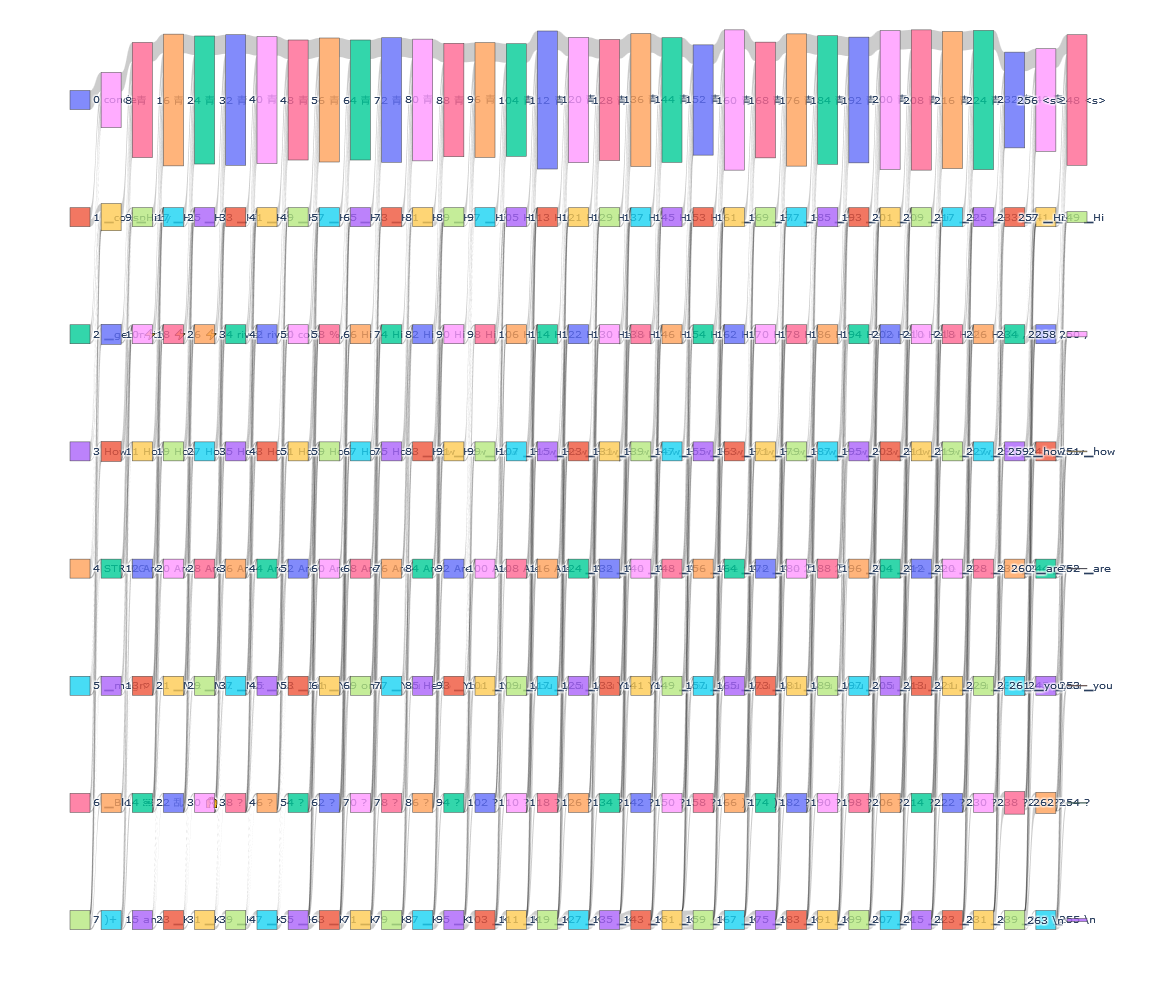

In [48]:
n_tok = len(dfs["input"].columns)

attentions = compute_batch_complete_padded_attentions(generated_output, range(0, 32))

# for key, df in dfs.items():        
nodexs = []
nodeys = []
labels = []
# Cycle through every layer of the model, gathering all blocks as nodes
for idx, row in dfs["input"].iterrows():
    # Generate coordinates for nodes
    xs = [i for i in range(len(row))]
    ys = [idx] * len(row)

    nodexs.append(xs)
    nodeys.append(ys)

    for x, y in zip(xs, ys):
        labels.append(row.iloc[x])

s = np.repeat([i for i in range(0, len(labels) - n_tok)], n_tok).astype(int).tolist()
t = np.array([[j for j in range(i, i + n_tok)] * n_tok for i in range(n_tok, len(labels), n_tok)]).flatten().astype(int).tolist()
v = np.array([[attentions[-1][i][j][::-1] for j in range(0, n_tok)][::-1] for i in reversed(range(0, 32))]).flatten()[::-1].astype(float).tolist()
s = [el_s for el_s, el_v in zip(s, v) if el_v > 0]
t = [el_t for el_t, el_v in zip(t, v) if el_v > 0]
v = [el_v for el_v in v if el_v > 0]

#nodexs = np.array(nodexs).flatten() 
#nodexs = (nodexs / nodexs.max()) * 0.1 + 0.0000001
#nodeys = np.array(nodeys).flatten()
#nodeys = (nodeys / nodeys.max()) * 3 + 0.0000001

# Vertical
#fig = go.Figure(go.Sankey(
#    orientation = "v",
#    arrangement='fixed',
#    valueformat=".5r",
#    node=dict(
#        align="left",
#        label=[f"{i} {l}" for i,l in enumerate(labels)],
#        y=nodexs,
#        x=nodeys[::-1],
#        pad=50
#    ),
#    link=dict(
#       source=s,
#       target=t,
#       value=v
#    )
#))
#fig.update_layout(font_size=10, width=1000, height=2700)

nodexs = np.array(nodexs).flatten() 
nodexs = (nodexs / nodexs.max()) + 0.0000001
nodeys = np.array(nodeys).flatten()
nodeys = (nodeys / nodeys.max()) + 0.0000001

fig = go.Figure(go.Sankey(
    orientation = "h",
    arrangement="fixed",
    valueformat=".5r",
    node=dict(
        align="left",
        label=[f"{i} {l}" for i,l in enumerate(labels)],
        y=nodexs,
        x=nodeys[::-1],
        pad=80
    ),
    link=dict(
       source=s,
       target=t,
       value=v
    )
))
fig.update_layout(font_size=10, width=4000, height=1000)

fig.show()

In [9]:
def create_transformer_plot(dfs, generated_output, exclude=[], heads=range(0, 1), multirep=False, max_heads=32, threshold=0.002, permanent_threshold=0.4):
    n_tok = len(dfs["input"].columns)
    attentions = compute_batch_complete_padded_attentions(generated_output, range(0, 32))
  
    nodexs = []
    nodeys = []
    labels = []
    # Cycle through every layer of the model, gathering all blocks as nodes
    for idx, row in dfs["input"].iterrows():
        # Generate coordinates for nodes
        xs = [i for i in range(len(row))]
        ys = [idx] * len(row)
    
        nodexs.append(xs)
        nodeys.append(ys)
    
        for x, y in zip(xs, ys):
            labels.append(row.iloc[x])

    def rev(arr, tot_len):
        return [tot_len - 1 - el for el in arr]

    s = np.repeat([i for i in range(0, len(labels) - n_tok)], n_tok).astype(int).tolist()
    t = np.array([[j for j in range(i, i + n_tok)] * n_tok for i in range(n_tok, len(labels), n_tok)]).flatten().astype(int).tolist()
    v = np.array([[attentions[-1][i][j][::-1] for j in range(0, n_tok)][::-1] for i in reversed(range(0, 32))]).flatten()[::-1].astype(float).tolist()
    s = [el_s for el_s, el_v in zip(s, v) if el_v > 0]
    t = [el_t for el_t, el_v in zip(t, v) if el_v > 0]
    v = [el_v for el_v in v if el_v > 0]

    nodexs = np.array(nodexs).flatten() 
    nodexs = (nodexs / nodexs.max()) + 0.0000001
    nodeys = np.array(nodeys).flatten()
    nodeys = (nodeys / nodeys.max()) + 0.0000001

    sankey_traces = go.Sankey(
        orientation = "h",
        arrangement="fixed",
        valueformat=".5r",
        node=dict(
            align="left",
            label=[f"{i} {l}" for i,l in enumerate(labels)],
            y=nodexs,
            x=nodeys[::-1],
            pad=80
        ),
        link=dict(
           source=s,
           target=t,
           value=v
        )
    )
    fig = go.Figure(data=[sankey_traces])
    fig.update_layout(font_size=10, width=4000, height=1000)

    return go.FigureWidget(fig), sankey_traces, None


In [10]:
def fix_dataframe_characters(df, replacements, multirep=False, columns=False):
    for old, new in replacements:
        df = df.map(lambda x: [i.replace(old, new) for i in x] if multirep else x.replace(old, new))
    if columns:
        for old, new in replacements:
            df.columns = df.columns.str.replace(old, new)
    return df

In [11]:
delta_point = 0.32
delta_arrow = 0.22

def gen_edges(
    edges, permanent_edges, attentions,
    generated_output, 
    nodexs, nodeys, 
    head, 
    exclude, 
    threshold, permanent_threshold,
):
    # Cycle through every layer of the model, gathering the aggregated coordinates for each node in a layer
    for idx, coords in enumerate(zip(nodexs, nodeys)):
        xs, ys = coords

        # Do not plot attention traces for the starting layer
        if idx != 0:
            # Compute the attention weights for the current layer and head
            attentions_lh = attentions[idx - 1]

            # Cycle through every node in the layer, gathering its coordinates 
            for i, c in enumerate(zip(xs, ys)):
                x, y = c

                # Cycle through every node in the PREVIOUS layer w.r.t. the current one, gathering its coordinates 
                for ii, cc in enumerate(zip(nodexs[idx - 1], nodeys[idx - 1])):
                    xx, yy = cc
                    weight = attentions_lh[ii][i]
                    
                    if x not in exclude and weight >= threshold:
                        if weight >= permanent_threshold:
                            # Create single permanent edge representing the attention weight
                            permanent_edges[head].append(go.Scattergl(
                                x=[x, (x+xx)/2, xx],
                                y=[y + delta_arrow, (y + yy + delta_arrow - delta_point)/2, yy - delta_point],
                                name="pedge",
                                mode="markers+lines",
                                marker=dict(size=[4, 0, 8], color="black", opacity=[1, 0, 1]),
                                marker_symbol=[1, 0, 5],
                                marker_line_width=0,
                                text=f"{str(weight)}",
                                hoverinfo=["none", "text", "none"],
                                line=dict(color="rgba(125,125,125,0.7)", width=2 * weight + 0.25),
                                customdata=[{"type": "edge", "P1": {"x": x, "y": y}, "P2": {"x": xx, "y":yy}}],
                                showlegend=False,
                            ))
                        else:
                            # Create single edge representing the attention weight
                            edges[head].append(go.Scattergl(
                                x=[x, (x+xx)/2, xx],
                                y=[y + delta_arrow, (y + yy + delta_arrow - delta_point)/2, yy - delta_point],
                                name="edge",
                                mode="markers+lines",
                                marker=dict(size=[4, 0, 8], color="black", opacity=[1, 0, 1]),
                                marker_symbol=[1, 0, 5],
                                marker_line_width=0,
                                text=f"{str(weight)}",
                                hoverinfo=["none", "text", "none"],
                                line=dict(color="rgba(125,125,125,0.7)", width=2 * weight + 0.25),
                                customdata=[{"type": "edge", "P1": {"x": x, "y": y}, "P2": {"x": xx, "y":yy}}],
                                showlegend=False,
                            ))

def create_transformer_plot(dfs, generated_output, exclude=[], heads=range(0, 1), multirep=False, max_heads=32, threshold=0.002, permanent_threshold=0.4):
    nodes = {key: [] for key in dfs.keys()}
    edges = {head: [] for head in heads}
    permanent_edges = {head: [] for head in heads}

    attentions = compute_batch_complete_padded_attentions(generated_output, range(0, max_heads))

    input_len = generated_output.attentions[0][0].size()[-1]
    n_layers = len(list(dfs.values())[0])
    in_tok =  list(dfs["input"].columns)
    out_tok =  list(dfs["output"].columns)
    len_tok = len(in_tok)

    pnodes = go.Scattergl(
        x=[i for i in range(0, len_tok)] * 2,
        y=[n_layers] * len_tok + [-1] * len_tok,
        name="pnode",
        mode="markers+text",
        marker=dict(
            size=22,
            color=  ( (["#bab0a2"] * (input_len-1)) + (["#ff9914"] * (len_tok - input_len + 1)) ) + 
                    ( (["#bab0a2"] * input_len) + (["#ff9914"] * (len_tok - input_len)) ),
            opacity=0.5
        ),
        marker_line_width=0,
        marker_symbol=0,
        text=out_tok + in_tok,
        textfont={"size": 12},
        textposition="middle center",
        hoverinfo="none",
        customdata=[{"type":"node"}],
        showlegend=False
    )
    
    for key, df in dfs.items():
        
        nodexs = []
        nodeys = []

        # Cycle through every layer of the model, gathering all blocks as nodes
        for idx, row in df.iterrows():

                # Generate coordinates for nodes
                xs = [i for i in range(len(row))]
                ys = [idx] * len(row)

                nodexs.append(xs)
                nodeys.append(ys)

                for x, y in zip(xs, ys):
                    srow = row[x]
                    color = "lightblue"
                    if x in exclude:
                        color = "red"

                    # Create nodes
                    nodes[key].append(go.Scattergl(
                        x=[x],
                        y=[y],
                        name="node",
                        mode="markers+text",
                        marker=dict(size=22, color=color, opacity=0.5),
                        marker_line_width=0,
                        marker_symbol=1,
                        text=srow[0] if multirep else srow,
                        textfont={"size": 11},
                        textposition="middle center",
                        hoverinfo="text" if multirep else "none",
                        hovertemplate="<br>".join([el for el in srow]) if multirep else None,
                        customdata=[{"type": "node", "rep_tokens": srow}],
                        showlegend=False
                    ))

    for head in heads:
        att = attentions[head]
        if head == -1:
            att = np.mean(attentions, axis=0)
        gen_edges(
            edges, permanent_edges, attentions[head],
            generated_output, 
            nodexs, nodeys, 
            head, 
            exclude, 
            threshold, permanent_threshold
        )

    # Create figure
    fig = go.Figure(data=pnodes)

    # Customize layout
    fig.update_layout(
        title="Transformer Weights Visualization",
        showlegend=True,
        xaxis=dict(showticklabels=False, zeroline=False),
        yaxis=dict(showticklabels=False, zeroline=False),
        plot_bgcolor='white',
        width=1100 + (len_tok * 40), height=1100 + (n_layers * 30),
        uirevision="const"
    )
    
    return go.FigureWidget(fig), nodes, (edges, permanent_edges)

In [12]:
def compute_edge_precache(nodes, edges, pedges, heads):
    return {
        (x,y):  { 
            head: {
                "edges": traces,
                "color_nodes": {
                    emb: compute_color_nodes(emb_nodes, traces + pedges[head], x, y) 
                    for emb, emb_nodes in nodes.items()
                }
            } for head in heads if (traces := compute_add_traces(edges[head], x, y)) or True
        }
        for x,y in [(x,y) for node_coords in [zip(node_batch.x, node_batch.y) for node_batch in list(nodes.values())[0]] for x,y in node_coords]
    }

def access_edge_cache(cache, x, y, attention_head, embedding, color_scale):
    add_traces = cache[(x,y)][attention_head]["edges"]
    add_color_nodes = cache[(x,y)][attention_head]["color_nodes"][embedding]
    add_color_nodes = [apply_color(node, trace, color_scale) for node, trace in add_color_nodes]
    return add_traces, add_color_nodes

def compute_add_traces(edges, x, y):
    return [
        el for el in edges if (
            el.customdata[0]["P1"]["x"] == x and el.customdata[0]["P1"]["y"] == y
        ) or (
            el.customdata[0]["P2"]["x"] == x and el.customdata[0]["P2"]["y"] == y
        )
    ]

def compute_color_nodes(nodes, add_traces, x, y):
    return [
        (node, trace)
        for trace in add_traces for node in filter(lambda n: n.y[0] == y - 1 and n.x[0] <= x, nodes) 
        if trace.customdata[0]["P1"]["x"] in node.x and trace.customdata[0]["P1"]["y"] in node.y and
            trace.customdata[0]["P2"]["x"] == x and trace.customdata[0]["P2"]["y"] == y
    ]

def apply_color(node, trace, color_scale):
    node["marker"]["color"] = pc.sample_colorscale(color_scale, float(trace.text))
    return node

In [13]:
def model_generate(model, tokenizer, prompt, max_extra_length, config, min_stop_length, stopping_tokens):
    inputs = tokenizer(prompt, return_tensors="pt")
    input_len = len(inputs.input_ids.squeeze().tolist())
    max_len = input_len + max_extra_length
    
    gen_config = config
    stopping_criteria = generate_stopping_criteria(stopping_tokens, input_len + min_stop_length)
    
    generated_output = model.generate(inputs.input_ids, generation_config=gen_config, max_length=max_len, stopping_criteria=stopping_criteria)
    outputs = generated_output.sequences.squeeze()
    text_output = tokenizer.decode(generated_output.sequences.squeeze()[input_len:])
    
    all_tokens = tokenizer.convert_ids_to_tokens(generated_output.sequences[0])
    input_tokens = all_tokens[0:input_len]
    generated_tokens = all_tokens[input_len:]
    
    return text_output, generated_output, {"in": input_tokens, "gen": generated_tokens}

def create_hidden_states_df(model, tokenizer, generated_output, gen_tokens, embedding, include_prompt, fix_characters, multirep=False):
    predictions = embed_hidden_states(model, generated_output.hidden_states, embedding, include_prompt=include_prompt, multirep=multirep, max_rep=5)
    rows = [[tokenizer.convert_ids_to_tokens(pred) for pred in pred_list] for pred_list in predictions]
    rows = rows if multirep else np.squeeze(rows)
    if embedding == "input":
        cols = gen_tokens["in"] + gen_tokens["gen"][:-1]
    else:
        cols = gen_tokens["in"][1:] + gen_tokens["gen"]
    df = pd.DataFrame(rows).T.sort_index(ascending=False).rename(columns={n: col for n, col in enumerate(cols)})
    df = fix_dataframe_characters(df, fix_characters, multirep=multirep, columns=True)
    return df

def create_attention_visualization(dfs, generated_output, exclude, heads, max_heads, compute_precache=True, multirep=False):
    figure, nodes, edges = create_transformer_plot(dfs, generated_output, exclude, heads=heads, max_heads=max_heads, multirep=multirep)
    edges, permanent_edges = edges
    permanent_traces = {head: {"edges": permanent_edges[head]} for head in heads}
    edge_precache = compute_edge_precache(nodes, edges, permanent_edges, heads) if compute_precache else None
    return figure, {"nodes": nodes, "edges": edges, "perm": permanent_traces}, edge_precache

In [14]:
#import ngrok
import asyncio
import dash
import diskcache
import uuid

#from kaggle_secrets import UserSecretsClient

from dash import dcc, html, ctx, Patch, DiskcacheManager
from dash.dependencies import Input, Output, State
from dash.exceptions import PreventUpdate

import dash_daq as daq
import plotly.colors as pc

import plotly.graph_objects as go

In [15]:
async def deploy_ngrok(address="http://127.0.0.1:8050"):
    listener = ngrok.forward(addr=address, authtoken=UserSecretsClient().get_secret("ngrok_key"))
    await asyncio.wait_for(listener, timeout=10)
    public_url = listener.result().url()
    print(f"Deploy URL: {public_url}")
    return listener.result()

In [25]:
color_scale = pc.sequential.Viridis

current_els = []
current_head = -1
current_emb = "output"

temp_edge_cache = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

cache = diskcache.Cache("./cache")
background_callback_manager = DiskcacheManager(cache)
app = dash.Dash("Test")

# Define the layout of the app
app.layout = html.Div([
    html.Div([
        html.Div([
            dcc.Textarea(id='model_input', placeholder ='Insert prompt...', style={'width': '100%', 'height': "50%"}),
            dcc.Loading(id="model_loading", type="dot", color="#873ba1", children =
                dcc.Textarea(id='model_output', readOnly=True, style={'width': '100%', 'height': "50%"})
            )
        ], style={"float": "left", "width": "70%", "height": "100%", "padding": 2}),
        html.Div([
            html.P(children="# of attention heads to load", style={"margin": "0"}),
            dcc.Dropdown([{"value": i, "label": i+1 if i >= 0 else "Average"} for i in range(-1, model_config.num_attention_heads)], id='model_generate_heads', value=-1, clearable=False),
            daq.NumericInput(id="min_stop_tokens", label="Min # tokens for stopping criteria", value=1, min=0, max=1024, labelPosition="right"),
            daq.NumericInput(id="max_new_tokens", label="Max # of generated tokens", value=10, min=0, max=1024, labelPosition="right"),
            dcc.Checklist(["Precache Results"], id="precache_results", inline=True),
            dcc.Checklist(["Compute Multiple Token Representations"], id="multirep_tokens", inline=True),
            html.Button('Generate', id='model_generate', style={"width": "100%", "height": "20px"}),
        ], style={"float": "right", "height": "100%", "width": "20%", "padding": 2}),
    ], style={"height": "140px"}),
    html.Div([
        html.P("Attention Head Selector"),
        dcc.Slider(marks={}, step=1, value=-1, id='attention_heads'),
        html.P("Embeddings Selector"),
        dcc.RadioItems(['input', 'output'], value='output', inline=True, id='embeddings'),
        dcc.Graph(id='scatterplot'),
    ]),
    dcc.Store(id="run_config"),
    dcc.Store(id="notify"),
    dcc.Store(id="graph_id")
])

# Aggregate run parameters data
@app.callback(
    Output('run_config', 'data'),
    [
        Input('model_generate_heads', 'value'),
        Input('min_stop_tokens', 'value'),
        Input('max_new_tokens', 'value'),
        Input('precache_results', 'value'),
        Input('multirep_tokens', 'value'),
    ]
)
def update_run_config(gen_heads, min_stop_tokens, max_new_tok, precache, multirep):
    return {
        "gen_heads": gen_heads,
        "min_stop_tokens": min_stop_tokens,
        "max_new_tok": max_new_tok,
        "precache": len(precache) if precache else None,
        "multirep": len(multirep) if multirep else None,
    }


@cache.memoize()
def model_output(prompt, session, run_config):
    prompt = prompt_structure.format(prompt=prompt)
    gen_config = GenerationConfig(
        pad_token_id=tokenizer.eos_token_id if tokenizer.eos_token_id else None,
        output_attentions=True, output_hidden_states=True, return_dict_in_generate=True
    )
    text_output, generated_output, gen_tokens = model_generate(
            model, tokenizer, prompt, 
            max_extra_length=run_config["max_new_tok"], 
            config=gen_config, 
            min_stop_length=run_config["min_stop_tokens"], stopping_tokens=stopgen_tokens
    )   
    dfs = {}
    for emb in ["input", "output"]:
        dfs[emb] = create_hidden_states_df(
            model, tokenizer, generated_output, gen_tokens, emb, 
            include_prompt=True, fix_characters=fix_characters,
            multirep=run_config["multirep"],
        )
    excludes = []
    if exclude_token_offset is not None:
        excludes.append(len(gen_tokens["in"]) - exclude_token_offset - 1)
    figure, fig_els, edge_precache = create_attention_visualization(
        dfs, generated_output, 
        exclude=excludes, 
        heads=range(-1, run_config["gen_heads"]+1), max_heads=model_config.num_attention_heads, 
        compute_precache=run_config["precache"],
        multirep=run_config["multirep"],
    )
    return text_output, fig_els, edge_precache, figure

# Define callback to generate output
@app.callback(
    [
        Output('model_output', 'value'),
        Output('scatterplot', 'figure', allow_duplicate=True),
        Output('attention_heads', 'marks'),
        Output('attention_heads', 'value'),
        Output('graph_id', 'data'),
        Output("notify", "data"),
    ],
    Input('model_generate', 'n_clicks'),
    [
        State('model_input', 'value'),
        State('run_config', 'data'),
    ],
    running=[(Output("model_generate", "disabled"), True, False)],
    prevent_initial_call=True,
    background=True,
    manager=background_callback_manager
)
def update_model_generation(click_data, prompt, run_config):
    if ctx.triggered_prop_ids:
        graph_id = str(uuid.uuid4())
        slider_marks = {i: f"Head {i}" for i in range(0, run_config["gen_heads"] + 1)}
        slider_marks.update({-1: "AVG"})
        text_output, fig_els, _, figure = model_output(prompt, graph_id, run_config)
        return text_output, figure, slider_marks, -1, graph_id, True
    raise PreventUpdate

#Define callback to update scatter plot
@app.callback(
    Output('scatterplot', 'figure'),
    [
        Input('scatterplot', 'clickData'),
        Input('attention_heads', 'value'),
        Input('embeddings', 'value'),
        Input('notify', 'data'),
    ],[
        State('model_input', 'value'),
        State('graph_id', 'data'),
        State('run_config', 'data'),
    ]
)
def update_scatter_plot(click_data, attention_head, embeddings, notify, prompt, graph_id, run_config):
    global current_els
    global current_head
    global current_emb
    global temp_edge_cache
    if ctx.triggered_prop_ids:
        _, fig_els, edge_precache, fig = model_output(prompt, graph_id, run_config)
        p = Patch()
        # Update for new graph available (suppresses other updates)
        if "notify.data" in ctx.triggered_prop_ids:
            add_traces = (fig_els["nodes"][current_emb] + fig_els["perm"][attention_head]["edges"])
            temp_edge_cache = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
        # Update for hovering over a plot node
        elif "scatterplot.clickData" in ctx.triggered_prop_ids and click_data and "customdata" in click_data["points"][0] and click_data["points"][0]["customdata"]["type"] == "node":
            x = click_data['points'][0]['x']
            y = click_data['points'][0]['y']
            
            # Check if all results are precached
            if edge_precache:
                add_edges, add_color_nodes = access_edge_cache(edge_precache, x, y, current_head, current_emb, color_scale)
            # Check if result is in temporary cache
            elif (x,y) in temp_edge_cache and attention_head in temp_edge_cache[(x,y)] and current_head in temp_edge_cache[(x,y)]["color_nodes"]:
                add_edges, add_color_nodes = access_edge_cache(temp_edge_cache, x, y, current_head, current_emb, color_scale)
            # Temporary cache miss
            else:
                add_edges = compute_add_traces(fig_els["edges"][current_head], x, y)
                add_color_nodes = compute_color_nodes(
                    fig_els["nodes"][current_emb], add_edges + fig_els["perm"][current_head]["edges"], x, y
                )
                temp_edge_cache[(x,y)][current_head]["edges"] = add_edges
                temp_edge_cache[(x,y)][current_head]["color_nodes"][current_emb] = add_color_nodes
                add_color_nodes = [apply_color(node, trace, color_scale) for node, trace in add_color_nodes]

            _ = [p["data"].remove(el) for el in current_els + add_color_nodes]
            
            add_traces = add_edges + add_color_nodes
            current_els = add_traces 
        # Update for changing attention head visualization
        elif "attention_heads.value" in ctx.triggered_prop_ids:
            _ = [p["data"].remove(el) for el in fig_els["perm"][current_head]["edges"] + current_els]
            add_traces = fig_els["perm"][attention_head]["edges"]
            current_head = attention_head
            current_els = []
        # Update for changing embeddings visualization
        elif "embeddings.value" in ctx.triggered_prop_ids:
            _ = [p["data"].remove(el) for el in fig_els["nodes"][current_emb] + current_els]
            add_traces = fig_els["nodes"][embeddings]
            current_emb = embeddings
            current_els = []
        else:
            raise PreventUpdate
        p["data"].extend(add_traces)
        return p
    raise PreventUpdate

In [19]:
#listener = await deploy_ngrok()

In [20]:
# await listener.close()